In [8]:
# assign directory
import git
from pathlib import Path
import os
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform import *
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "dataset-preparation"))

data_dir  = os.path.join(ROOT_DIR, 'raw-data', 'ravdess','full-ravdess-wav')
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

## Audio Processing using Librosa and soundfile

* Detects audio files that contain clipping and removes them from the data set
* Filters out beginning and end silence 
* Normalizes loudness

In [9]:
import librosa #Need to pip install librosa 
import soundfile as sf #Need to pip install soundfile

In [12]:
#Creates new wav files that have been processed

CLIP_THRESHOLD = 0.99
OUTPUT_DIR = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-wav-processed')

def is_clipped(y, threshold = CLIP_THRESHOLD):
    return np.any(np.abs(y) >= threshold)

def normalize_peaks(y):
    return y / np.max(np.abs(y)) if np.max(np.abs(y)) > 0 else y

def normalize_pitch_shifting(y, sr, target_hz=150.0):
    f0, voiced_flag, _ = librosa.pyin(y, 
                                      fmin=librosa.note_to_hz('C2'), 
                                      fmax=librosa.note_to_hz('C7'))
    
    voiced_f0 = f0[voiced_flag]
    voiced_f0 = voiced_f0[~np.isnan(voiced_f0)]

    current_pitch_hz = np.median(voiced_f0)
    if current_pitch_hz <= 0:
        return y
    n_steps = 12 * np.log2(target_hz / current_pitch_hz)

    y_shifted = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)
    
    return y_shifted

def process_audio_file(filepath, outpath):
    y, sr = librosa.load(filepath, sr=None)

    if is_clipped(y):
        return

    y_trimmed, _ = librosa.effects.trim(y, top_db=20)

    y_loudness_normalized = normalize_peaks(y_trimmed) 
    
    # pitch normalization
    y_normalized = normalize_pitch_shifting(y_loudness_normalized, sr, target_hz=150.0)

    sf.write(outpath, y_normalized, sr)

try:
    os.mkdir(OUTPUT_DIR)
except FileExistsError:
    pass

total_files = len(file_names)
print(f"Starting processing for {total_files} files...")

for i, filename in enumerate(file_names):
    print(f"Processing file {i + 1}/{total_files}: {filename}", end='\r')
    if filename.lower().endswith('wav'):
        path_in = os.path.join(data_dir, filename)
        path_out = os.path.join(OUTPUT_DIR, filename)
        process_audio_file(path_in, path_out)
        
print("\nProcessing complete. All files have been handled.")


Starting processing for 1440 files...
Processing file 1440/1440: 03-01-08-02-02-02-24.wav
Processing complete. All files have been handled.


In [13]:
#Changes dataset to post-processed dataset
data_dir = OUTPUT_DIR
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

## numpy representation

using `scipy.io.wavfile.read(filename)` to intake .wav audio files 

> returns 
> * rate, registing the hertz of the audio 
> * data, an array with each index representing a point in time for the audio and its value representing amplitude at said time 
>   * index position divided by the length of array represents its temporal occurence in seconds

In [14]:
from scipy.io import wavfile

In [15]:
wav_rates, wav_coeffs = zip(*[wavfile.read(file) for file in file_list])
wav_rates = np.array(wav_rates)
wav_coeffs = np.array(wav_coeffs, dtype="object")

In [16]:
assert len(wav_rates) == len(wav_rates), "Check for lossy data in .wav scipy numpy representation"
n = len(wav_rates)
n

1420

In [17]:
wav_lengths = pd.Series(wav_coeffs).apply(len) / wav_rates[0]

## info parsing to .csv

file naming conventions (from RAVDESS)

In [18]:
modalities = {
    "01": "full-AV", 
    "02": "video-only",
    "03": "audio-only"
} 

channels = {
    "01": "speech",
    "02": "song"
}

emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "suprised",
} 

intensities = {
    "01": "normal",
    "02": "strong"
}

statements = {
    "01": "Kids are talking by the door",
    "02": "Dogs are sitting by the door"
}

speaker_sex = ["female", "male"] 

In [19]:
ravdess_cols = ["modality", "channel", "emotion", "intensity", "statement", "repetition", "actor", "sex", "filename"]
rows = []

for f in file_names:
    if f != ".DS_Store":
        parsed_info = f[:-4].split("-")

        modality = modalities[parsed_info[0]]
        channel = channels[parsed_info[1]]
        emotion = emotions[parsed_info[2]]
        intensity = intensities[parsed_info[3]]
        sentence = statements[parsed_info[4]]
        rep = int(parsed_info[5])
        no1 = int(parsed_info[6])
        sx = speaker_sex[no1 % 2]

        rows.append({
            "modality": modality,
            "channel": channel,
            "emotion": emotion,
            "intensity": intensity,
            "statement": sentence,
            "repetition": rep,
            "actor": no1,
            "sex": sx,
            "filename": f
        })

ravdess_df = pd.DataFrame(rows, columns=ravdess_cols)


ravdess_df["length (s)"] = wav_lengths
ravdess_df["rate (Hz)"] = wav_rates
ravdess_df["amplitudes"] = wav_coeffs

ravdess_df.head()

,modality,channel,emotion,intensity,statement,repetition,actor,sex,filename,length (s),rate (Hz),amplitudes
0,audio-only,speech,neutral,normal,Kids are talking by the door,1,1,male,03-01-01-01-01-01-01.wav,1.194667,48000,"[-574, -973, -726, 313, 167, 472, -1095, 280, ..."
1,audio-only,speech,neutral,normal,Kids are talking by the door,1,2,female,03-01-01-01-01-01-02.wav,1.493333,48000,"[146, -628, -1277, -1397, -1161, -956, 119, 12..."
2,audio-only,speech,neutral,normal,Kids are talking by the door,1,3,male,03-01-01-01-01-01-03.wav,1.344000,48000,"[-254, 153, 821, 624, -420, -822, -730, -237, ..."
3,audio-only,speech,neutral,normal,Kids are talking by the door,1,4,female,03-01-01-01-01-01-04.wav,1.269333,48000,"[1074, 278, -595, -807, -2617, -797, 1481, 233..."
4,audio-only,speech,neutral,normal,Kids are talking by the door,1,5,male,03-01-01-01-01-01-05.wav,1.525333,48000,"[-392, 356, 378, -647, -338, 207, 76, -549, 23..."


In [20]:
xport_name = "full-ravdess.csv"
EXPORT_DIR = os.path.join(ROOT_DIR, "raw-data", "ravdess")
EXPORT_PATH = os.path.join(EXPORT_DIR, xport_name)

ravdess_df.to_csv(EXPORT_PATH)

## npz representation export

In [21]:
EXPORT_DIR = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-npz')

try:
    os.mkdir(EXPORT_DIR)
except FileExistsError:
    pass

for f in np.arange(len(file_list)):
    coef = wav_coeffs[f]
    file_name = file_list[f][-24:-4] ## removes the .wav naming convention

    np.savez(os.path.join(EXPORT_DIR, file_name))

## banding

consideration for a "banding method" to group adjacent audio bytes in a similar fashion to how the image teams doing 

* tied to the transformation in use 

# Wavelet representation
Morlet continuous wavelet transform on some example files to start

In [22]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

In [23]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

rate, signal = wavfile.read(file_list[test_file_idx])

wavelet = 'cmor1.5-1.0' # complex morlet: bandwidth = 1.5, center frequency = 1.0
low_freq, high_freq = 80, 8000  # typical range for human speech
num_scales = 100  # can be adjusted for computational efficiency

frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_scales)
scales = pywt.frequency2scale(wavelet, frequencies / rate)
coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/rate)

modality                                             audio-only
channel                                                  speech
emotion                                                 neutral
intensity                                                normal
statement                          Kids are talking by the door
repetition                                                    2
actor                                                        19
sex                                                        male
filename                               03-01-01-01-01-02-19.wav
length (s)                                                1.344
rate (Hz)                                                 48000
amplitudes    [231, 172, 31, 234, 236, 38, 157, 183, 149, 30...
Name: 42, dtype: object


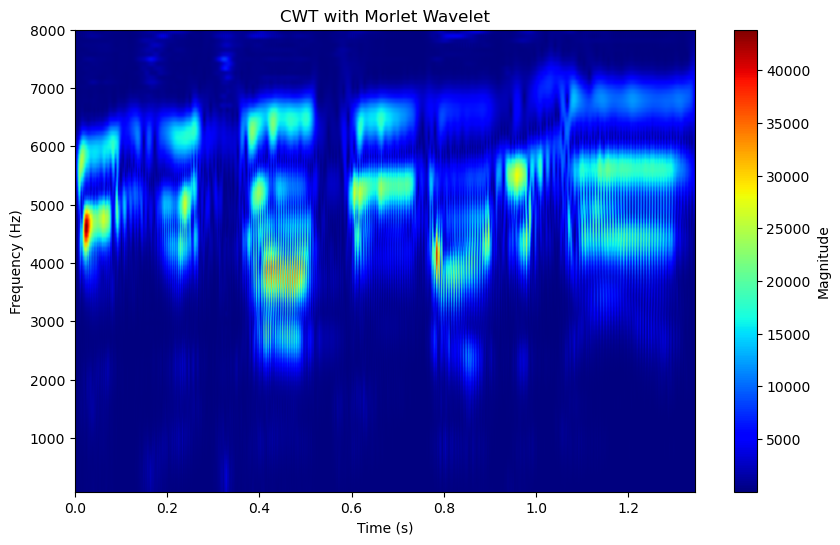

In [24]:
plt.figure(figsize=(10, 6))
plt.imshow(
    np.abs(coefs),
    aspect='auto',
    cmap='jet',
    extent=[0, len(signal)/rate, low_freq, high_freq]
)
plt.colorbar(label='Magnitude')
# plt.yscale('log') # log scale frequency axis
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('CWT with Morlet Wavelet')
plt.show()

In [25]:
# generalize above logic into function

def cwt_file(filename, wavelet='cmor1.5-1.0', low_freq=80, high_freq=8000, num_scales=100, visualize=False, title='CWT with Morlet Wavelet'):
    rate, signal = wavfile.read(os.path.join(data_dir, filename)) # currently references global data_dir
    frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_scales)
    scales = pywt.frequency2scale(wavelet, frequencies / rate)
    coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/rate)

    if visualize:
        plt.figure(figsize=(10, 6))
        plt.imshow(
            np.abs(coefs),
            aspect='auto',
            cmap='jet',
            extent=[0, len(signal)/rate, low_freq, high_freq]
        )
        plt.colorbar(label='Magnitude')
        # plt.yscale('log')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(title)
        plt.show()

    return coefs, freqs

In [27]:
# compare male versus female

from functools import reduce

def homogenize(df, *cols):
    return df[reduce(lambda a, b: a & b, (df[col] == df[col][0] for col in cols), np.ones(df.shape[0]))]

hom_df = homogenize(ravdess_df, 'statement', 'emotion', 'intensity')
male_vs_female = hom_df.groupby('sex').first()
male_vs_female

,modality,channel,emotion,intensity,statement,repetition,actor,filename,length (s),rate (Hz),amplitudes
sex,,,,,,,,,,,
female,audio-only,speech,neutral,normal,Kids are talking by the door,1,2,03-01-01-01-01-01-02.wav,1.493333,48000,"[146, -628, -1277, -1397, -1161, -956, 119, 12..."
male,audio-only,speech,neutral,normal,Kids are talking by the door,1,1,03-01-01-01-01-01-01.wav,1.194667,48000,"[-574, -973, -726, 313, 167, 472, -1095, 280, ..."


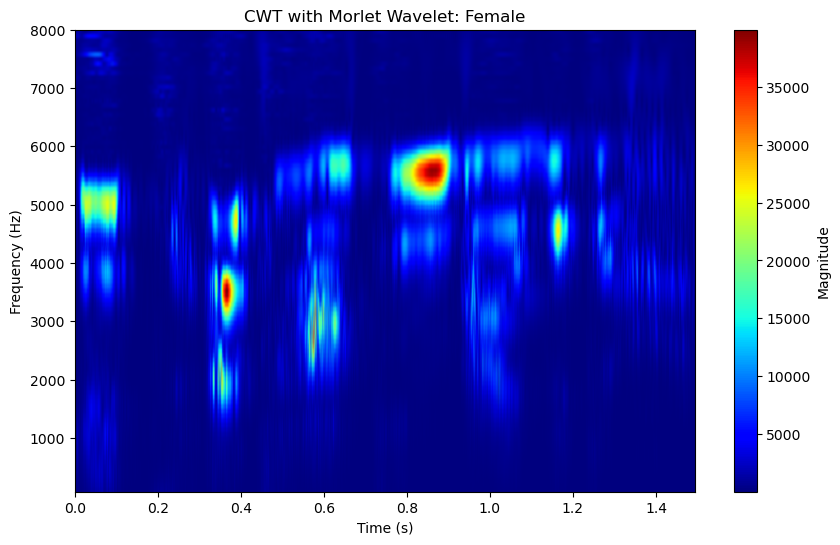

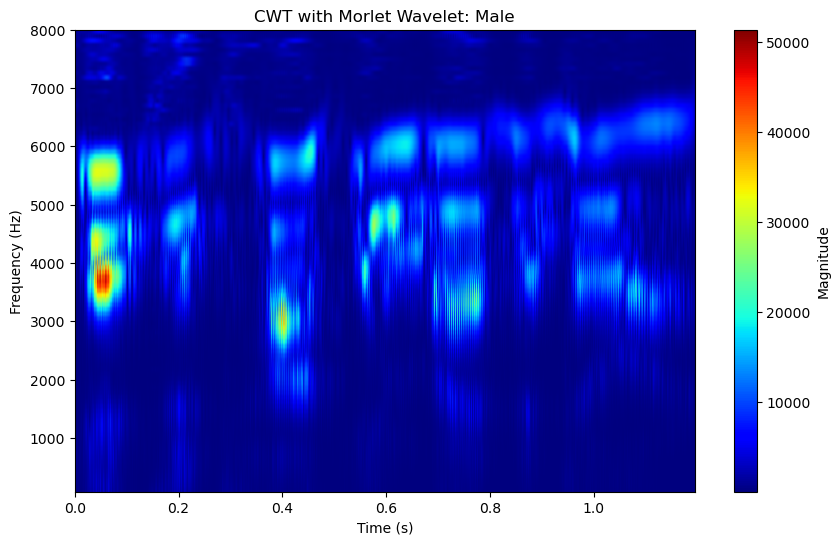

In [28]:
for sex, filename in zip(male_vs_female.index, male_vs_female['filename']):
    cwt_file(filename, visualize=True, title=f'CWT with Morlet Wavelet: {sex.capitalize()}')

# Fourier Representation

In [29]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

rate, signal1 = wavfile.read(file_list[test_file_idx])
signal2, rate_l = librosa.load(file_list[test_file_idx], sr=None)

modality                                             audio-only
channel                                                  speech
emotion                                                 neutral
intensity                                                normal
statement                          Kids are talking by the door
repetition                                                    2
actor                                                        19
sex                                                        male
filename                               03-01-01-01-01-02-19.wav
length (s)                                                1.344
rate (Hz)                                                 48000
amplitudes    [231, 172, 31, 234, 236, 38, 157, 183, 149, 30...
Name: 42, dtype: object


In [30]:
print(rate == rate_l)
print(signal1 / signal2)
# just scaled down by 2**15 (normalized by maximumum signal)
signal = signal2

True
[32768. 32768. 32768. ... 32768. 32768. 32768.]


C:\Users\elile\AppData\Local\Temp\ipykernel_36200\1270320814.py:2: RuntimeWarning: invalid value encountered in divide
  print(signal1 / signal2)


In [31]:
fft_signal = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), 1/rate)

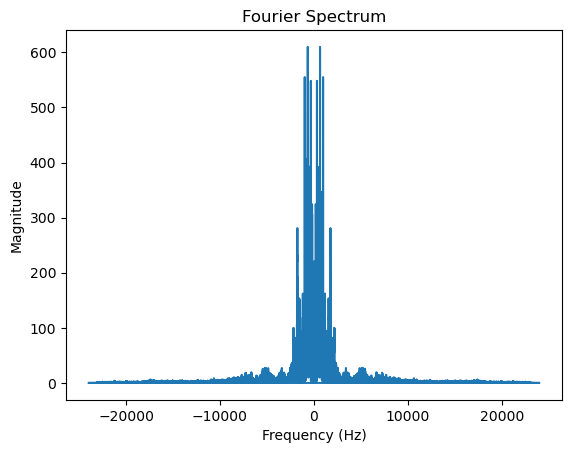

In [32]:
plt.plot(frequencies, np.abs(fft_signal))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Spectrum')
plt.show()

Symmetry: A coefficient corresponding to a negative frequency is the complex complex conjugate of the coefficient corresponding to the positive frequency

In [33]:
negative_idx = len(frequencies) // 2 # first half nonnegative, second half negative
assert negative_idx == (frequencies < 0).argmax()
assert (frequencies[1:negative_idx] == -frequencies[negative_idx + 1:][::-1]).all() # exclude one negative due to parity mismatch
positive_signals = fft_signal[1:negative_idx]
negative_signals = fft_signal[negative_idx + 1:][::-1]
assert ((positive_signals + negative_signals).imag == 0).all() # all real
print(positive_signals)
print(negative_signals)

[ 1.4767661e+01+1.2487936e+01j  4.1159898e-01+6.2781792e+00j
 -1.0644685e+01+4.6173501e+00j ...  1.0387697e-02-3.0950126e-03j
  1.2196062e-02-2.7388223e-03j  8.2437145e-03+5.1917978e-05j]
[ 1.4767661e+01-1.2487936e+01j  4.1159898e-01-6.2781792e+00j
 -1.0644685e+01-4.6173501e+00j ...  1.0387697e-02+3.0950126e-03j
  1.2196062e-02+2.7388223e-03j  8.2437145e-03-5.1917978e-05j]


In [34]:
def fft_file(filename, visualize=False, title='Fourier Spectrum'):
    rate, signal = librosa.load(os.path.join(data_dir, filename), sr=None)
    fft_signal = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1/rate)

    if visualize:
        plt.plot(frequencies, np.abs(fft_signal))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(title)
        plt.show()
    
    return fft_signal, frequencies

## Short-Time Fourier Transform

In [35]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

signal, rate = librosa.load(file_list[test_file_idx], sr=None)

modality                                             audio-only
channel                                                  speech
emotion                                                 neutral
intensity                                                normal
statement                          Kids are talking by the door
repetition                                                    2
actor                                                        19
sex                                                        male
filename                               03-01-01-01-01-02-19.wav
length (s)                                                1.344
rate (Hz)                                                 48000
amplitudes    [231, 172, 31, 234, 236, 38, 157, 183, 149, 30...
Name: 42, dtype: object


In [36]:
S = librosa.stft(signal)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)

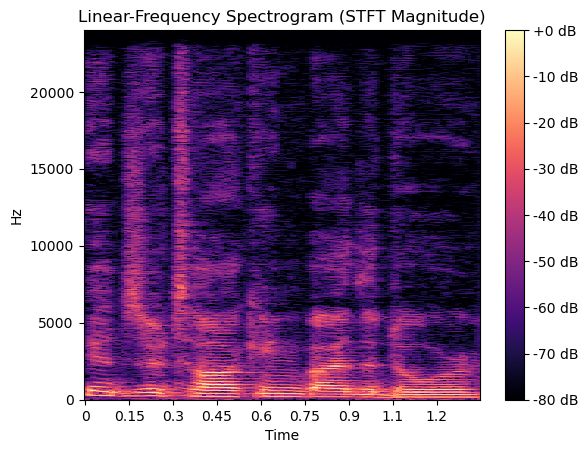

In [37]:
librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=rate)
plt.colorbar(format="%+2.f dB")
plt.title('Linear-Frequency Spectrogram (STFT Magnitude)');

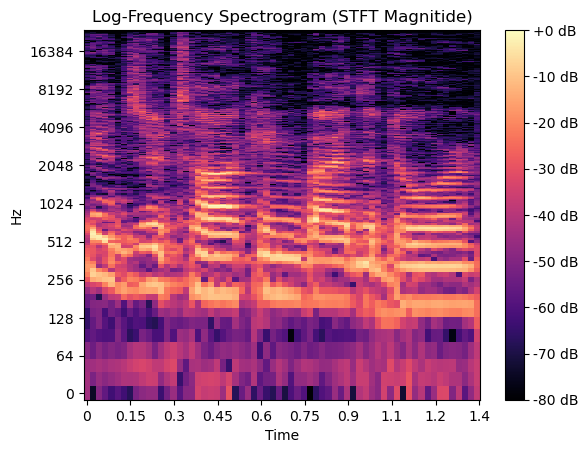

In [38]:
D_1024 = librosa.amplitude_to_db(np.abs(librosa.stft(signal, hop_length=1024)), ref=np.max)
librosa.display.specshow(D_1024, y_axis='log', sr=rate, x_axis='time', hop_length=1024)
plt.colorbar(format="%+2.f dB")
plt.title('Log-Frequency Spectrogram (STFT Magnitide)');

# Next steps: ERBlet

Implemented by [LTFAT](https://ltfat.org/) (Large Time-Frequency Analysis Toolbox) in Matlab/Octave
- ERBlet Paper: https://ieeexplore.ieee.org/document/6637697
- LTFAT Erblet documentation: https://ltfat.org/doc/filterbank/erblett.html (deprecated? see [file](https://github.com/ltfat/ltfat/blob/main/deprecated/erblett.m) for alternative method)
- LTFAT Github: https://github.com/ltfat/ltfat

First task will be to install the toolbox and figure out how to interop it with Python.